## Define Model

$$
\begin{matrix}
\text{Input 1: text}, X_1 & \rightarrow & \text{embed}: E(X_1) & \rightarrow & N_1(E(X_1)) \\
  & & & & \searrow \\
  & & & &          & \oplus \rightarrow N_3 \bigg( \underbrace{N_1(E(X_1))}_\text{text}, \underbrace{N_2(X_2)}_\text{func rating} \bigg) \\
  & & & & \nearrow \\
& & \text{Input 2: function rating}, X_2 & \rightarrow & N_2(X_2) \\
\end{matrix}
$$

#Import required libraries

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Load tokenizer and model

In [ ]:
# Setting Hugging face token
import os
os.environ["HF_TOKEN"] = "Your HF token" # place your HF token here

from huggingface_hub import login
login(token=os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
# Load tokenizer and model from sentence-transformers
model_name = "sentence-transformers/all-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Model

In [ ]:
def stars_from_rating(rating):
    return "★" * int(rating)

def create_nn_model(bert_output_dim, num_of_dense):
    text_input = Input(shape=(bert_output_dim,), name="text_input")
    x = text_input
    num_neurons = 1024
    for _ in range(num_of_dense):
        num_neurons = max(32, int(num_neurons / 2))
        x = Dense(num_neurons, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

    func_rating_input = Input(shape=(1,), name="func_rating_input")
    y = Dense(16, activation='relu')(func_rating_input)
    concatenated = Concatenate()([x, y])
    output = Dense(5, activation='softmax', name="output")(concatenated)

    model = Model(inputs=[text_input, func_rating_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Loading Dataset

In [ ]:
df = pd.read_csv("/content/Combined.csv")

In [ ]:
df.head()

,user_prompt,url_to_check,func_rating,custom_rating
0,"I have just been on an international flight, c...",https://www.mayoclinic.org/healthy-lifestyle/i...,2,3
1,What are the benefits of a vegetarian diet?,https://www.nhs.uk/live-well/eat-well/how-to-e...,2,4
2,What are the benefits of a vegetarian diet?,https://www.nhs.uk/live-well/eat-well/how-to-e...,2,2
3,What are the benefits of a vegetarian diet?,https://pubmed.ncbi.nlm.nih.gov/37226630/#:~:t...,2,3
4,How to improve mental health during stressful ...,https://www.who.int/news-room/questions-and-an...,3,3


# Encoding the given data and verfying the dimensionality/Shape

In [ ]:
# Tokenize and prepare data using Sentence Transformers
encoded_inputs = tokenizer(df["user_prompt"].tolist(), padding=True, truncation=True, return_tensors="np")
X_text = bert_model(encoded_inputs['input_ids'])[0][:, 0, :].numpy()
X_numeric = np.array(df["func_rating"]).reshape(-1, 1)
y = df["custom_rating"].values - 1
y_one_hot = to_categorical(y, num_classes=5)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.flatten())
class_weight_dict = {i: class_weights[i] for i in range(5)}

#Creating and training the model

In [ ]:
# Create and train the model
num_of_dense_layers = 3
bert_output_dim = X_text.shape[1]
model = create_nn_model(bert_output_dim, num_of_dense_layers)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

history = model.fit(
    {"text_input": X_text, "func_rating_input": X_numeric},
    y_one_hot,
    epochs=60,
    batch_size=8,
    validation_split=0.1,
    verbose=2,
    callbacks=[lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


32/32 - 5s - 144ms/step - accuracy: 0.1818 - loss: 13.2955 - val_accuracy: 0.0690 - val_loss: 11.0481 - learning_rate: 3.0000e-04
Epoch 2/60
32/32 - 1s - 29ms/step - accuracy: 0.2688 - loss: 12.8457 - val_accuracy: 0.2414 - val_loss: 10.9448 - learning_rate: 3.0000e-04
Epoch 3/60
32/32 - 1s - 18ms/step - accuracy: 0.2846 - loss: 12.8797 - val_accuracy: 0.2414 - val_loss: 10.8910 - learning_rate: 3.0000e-04
Epoch 4/60
32/32 - 1s - 20ms/step - accuracy: 0.3004 - loss: 12.4130 - val_accuracy: 0.5172 - val_loss: 10.7811 - learning_rate: 3.0000e-04
Epoch 5/60
32/32 - 0s - 11ms/step - accuracy: 0.2925 - loss: 12.2475 - val_accuracy: 0.5517 - val_loss: 10.7111 - learning_rate: 3.0000e-04
Epoch 6/60
32/32 - 0s - 13ms/step - accuracy: 0.3953 - loss: 11.6460 - val_accuracy: 0.6207 - val_loss: 10.6197 - learning_rate: 3.0000e-04
Epoch 7/60
32/32 - 1s - 18ms/step - accuracy: 0.3992 - loss: 11.7963 - val_accuracy: 0.6552 - val_loss: 10.5406 - learning_rate: 3.0000e-04
Epoch 8/60
32/32 - 0s - 12ms/s

# Plotting training and validation loss

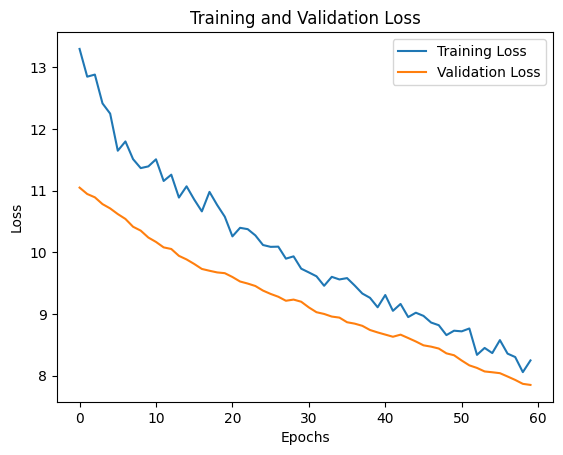

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [ ]:
# Compute Accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

Final Training Accuracy: 58.50%
Final Validation Accuracy: 72.41%


In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 512)            │        197,120 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 512)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 512)            │          2,048 │ leaky_re_lu_6[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │        131,328 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 256)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 256)            │          1,024 │ leaky_re_lu_7[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         32,896 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 128)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 128)            │            512 │ leaky_re_lu_8[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 16)             │             32 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 144)            │              0 │ dropout_8[0][0],       │
│ (Concatenate)             │                        │                │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 5)              │            725 │ concatenate_2[0][0]    │
└──────────────────────

 Total params: 1,093,473 (4.17 MB)

 Trainable params: 363,893 (1.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 727,788 (2.78 MB)

# Testing our model

In [ ]:
# Testing Code
def test_model():
    test_texts = [
        "How to improve focus and concentration?",
        "What are the side effects of lack of sleep?",
        "Best techniques to manage stress effectively?",
        "How does regular exercise impact mental health?",
        "What are the benefits of meditation and mindfulness?",
        "Was moon landing fake?"
    ]
    encoded_test_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="np")
    X_text_test = bert_model(encoded_test_inputs['input_ids'])[0][:, 0, :].numpy()
    X_func_test = np.array([5, 4, 3, 4, 2, 1]).reshape(-1, 1)

    predictions = model.predict({"text_input": X_text_test, "func_rating_input": X_func_test})
    predicted_classes = np.argmax(predictions, axis=1) + 1
    star_ratings = [stars_from_rating(r) for r in predicted_classes]

    for i, text in enumerate(test_texts):
        print(f"Prompt: {text}")
        print(f"Predicted Score: {predicted_classes[i]}")
        print(f"Stars: {star_ratings[i]}")
        print("-" * 50)

test_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Prompt: How to improve focus and concentration?
Predicted Score: 3
Stars: ★★★
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Score: 3
Stars: ★★★
--------------------------------------------------
Prompt: Best techniques to manage stress effectively?
Predicted Score: 3
Stars: ★★★
--------------------------------------------------
Prompt: How does regular exercise impact mental health?
Predicted Score: 3
Stars: ★★★
--------------------------------------------------
Prompt: What are the benefits of meditation and mindfulness?
Predicted Score: 5
Stars: ★★★★★
--------------------------------------------------
Prompt: Was moon landing fake?
Predicted Score: 2
Stars: ★★
--------------------------------------------------


## Create Repo on HF

In [ ]:
! pip install --upgrade huggingface_hub

In [ ]:
import os
from huggingface_hub import HfApi, login

os.environ["HUGGINGFACE_TOKEN"] = "Your HF token"  # Replace with your token

hf_username = " "#Place your user name here
repo_name = "my-tensorflow-model"
repo_id = f"{hf_username}/{repo_name}"

token = os.environ.get("HUGGINGFACE_TOKEN")

login(token=token)

api = HfApi()

api.create_repo(repo_id=repo_id, exist_ok=True)

print(f"Repository created: https://huggingface.co/{repo_id}")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Repository created: https://huggingface.co/Aditya-1911/my-tensorflow-model


## Push Artifacts on HF

In [ ]:
import pickle
import os
from huggingface_hub import HfApi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define save directory
model_dir = "./saved_model_Classification"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Upload model and tokenizer to Hugging Face
repo_id = f"username/{repo_name}"  # Change as needed add HF user name before "/"
api = HfApi()

api.upload_file(path_or_fileobj=model_path, path_in_repo="model.keras", repo_id=repo_id)
api.upload_file(path_or_fileobj=tokenizer_path, path_in_repo="tokenizer.pkl", repo_id=repo_id)

print(f"Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}")

model.keras:   0%|          | 0.00/4.45M [00:00<?, ?B/s]

tokenizer.pkl:   0%|          | 0.00/468k [00:00<?, ?B/s]

Model and tokenizer successfully pushed to: https://huggingface.co/Aditya-1911/my-tensorflow-model


## Download Model Artifact from HF

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import hf_hub_download

# Ensure correct backend (optional)
#os.environ["KERAS_BACKEND"] = "jax"

# Define repo ID and model filename
repo_id = "username/my-tensorflow-model" #Add your HF username before/
filename = "model.keras"

# Download the model
model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Define the registered function before loading
#@keras.saving.register_keras_serializable()
def bert_layer(inputs):
    return bert_model(inputs[0], attention_mask=inputs[1])[0][:, 0, :]

# Load the Keras model with custom objects
new_model = keras.models.load_model(model_path, custom_objects={"bert_layer": bert_layer})

print("Model loaded successfully!")


model.keras:   0%|          | 0.00/4.45M [00:00<?, ?B/s]

Model loaded successfully!


## Local Inference

In [ ]:
import pickle
from huggingface_hub import hf_hub_download
from tensorflow import keras
import numpy as np

# Download model
model_path = hf_hub_download(repo_id=repo_id, filename="model.keras")
new_model = keras.models.load_model(model_path)

# Download tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.pkl")

# Load the tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded successfully!")

test_texts = [
        "How to improve focus and concentration?",
        "What are the side effects of lack of sleep?",
        "Best techniques to manage stress effectively?",
        "How does regular exercise impact mental health?",
        "What are the benefits of meditation and mindfulness?",
        "Was moon landing fake?"
    ]
encoded_test_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="np")
X_text_test = bert_model(encoded_test_inputs['input_ids'])[0][:, 0, :].numpy()
X_func_test = np.array([5, 4, 3, 4, 2, 1]).reshape(-1, 1)

predictions = model.predict({"text_input": X_text_test, "func_rating_input": X_func_test})
predicted_classes = np.argmax(predictions, axis=1) + 1
star_ratings = [stars_from_rating(r) for r in predicted_classes]

for i, text in enumerate(test_texts):
    print(f"Prompt: {text}")
    print(f"Predicted Score: {predicted_classes[i]}")
    print(f"Stars: {star_ratings[i]}")
    print("-" * 50)

Model and tokenizer loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prompt: How to improve focus and concentration?
Predicted Score: 3
Stars: ★★★
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Score: 3
Stars: ★★★
--------------------------------------------------
Prompt: Best techniques to manage stress effectively?
Predicted Score: 3
Stars: ★★★
--------------------------------------------------
Prompt: How does regular exercise impact mental health?
Predicted Score: 3
Stars: ★★★
--------------------------------------------------
Prompt: What are the benefits of meditation and mindfulness?
Predicted Score: 5
Stars: ★★★★★
--------------------------------------------------
Prompt: Was moon landing fake?
Predicted Score: 2
Stars: ★★
--------------------------------------------------
